### Glacier Ice and Snow Calculator.

Steps for the initial part of the project:-
1 - Gather Satellite images of a glacier mountainscape (Kenai Mountains) - Using Landsat images
2 - Present 3 different time periods (1999, 2010 - 2025 using landsat)
3 - Covert images into false colour composite
4 - Conduct a classification on both landsat scenes
5 - calculate area coverage (km2)
6 - present results


Potential expansions:-
- Expand the study period and get more mountains glaciers
- Compare volume changes

In [1]:
import os
import geopandas as gpd
import rasterio as rio
import rasterio.merge
import shapely
import usgs

In [112]:
#As Landsat imagery is going to be the source of satellite imagery covering the glaciers used in this study, the first step is to log in to the USGS API using a username and token
from usgs import api

# Open and manually read the username from the .usgs_user file in the home directory
with open('C:/Users/couse/.usgs_user', 'r') as usertext:
    username = usertext.read()

#Open and manually read the password/token from the.usgs_token in the home directory
with open('C:/Users/couse/.usgs_token', 'r') as tokentext:
    password = tokentext.read()
    
# Login to the API using the username and the token(API_KEY provided by the USGS) as password
login = api.login(username, password, save=True)

#Below the API Key (token) is extracted separately as it will be used for the functions later in the script
api_key = login['data']

In [108]:
# To get a better understanding of all the functions and methods available in the 'usgs.api' a directory is printed below
print(dir(usgs.api))

['FuturesSession', 'HTTPAdapter', 'Retry', 'TMPFILE', 'USGSAuthExpiredError', 'USGSError', 'USGS_API', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__version__', '_check_for_usgs_error', '_create_session', '_get_api_key', 'dataset_download_options', 'dataset_filters', 'dataset_search', 'datetime', 'download_options', 'download_request', 'json', 'login', 'logout', 'os', 'payloads', 'requests', 'scene_metadata', 'scene_search']


In [32]:
help(api.dataset_search)

Help on function dataset_search in module usgs.api:

dataset_search(dataset=None, catalog=None, ll=None, ur=None, start_date=None, end_date=None, api_key=None)



In [ ]:
Available_Satellites = api.dataset_search()
print(Available_Satellites)

In [4]:
# The Landsat images comes from the EarthExplorer (EE) dataset (node), in order to get an idea of what Landsat data is available
satellite_avail = api.dataset_search("landsat", "EE", api_key=api_key)

# The code below prints out each Satellites dataset identified in the api.dataset_search which are available for this project using the provided API Key
for dataset in satellite_avail['data']:
        print(dataset['datasetAlias'])

esat_etm_nopan
esat_etm_pan
ortho_mosaic_etm
geos_5_fp_it
geos_5_it
lima
landsat_mss_c2_l1
landsat_tm_c2_l1
landsat_tm_c2_l2
landsat_ba_tile_c2
landsat_dswe_tile_c2
landsat_fsca_tile_c2
landsat_fsca_tile_stat_c2
landsat_ard_tile_c2
landsat_etm_c2_l1
landsat_etm_c2_l2
landsat_ot_c2_l1
landsat_ot_c2_l2
landsat_band_files_c2_l1
landsat_band_files_c2_l2
lima_mosaic
merra_2_c2
ortho_mss_scene
mss_film
rbv_film
sys_etm
esat_tm
tm_film
ortho_mosaic
viirs_atmos


In [113]:
# Get filters for the dataset and node
filters = api.dataset_filters('landsat_ot_c2_l1', api_key)

# Show filter options
import json
print(json.dumps(filters))

{"requestId": 1984592229, "version": "stable", "sessionId": 315040452, "data": [{"id": "5e81f14fe3c40983", "legacyFieldId": 27678, "dictionaryLink": "https://www.usgs.gov/centers/eros/science/landsat-collection-2-data-dictionary#landsat_product_id", "fieldConfig": {"type": "Text", "filters": [{"type": "Application\\Filter\\Like", "options": []}], "options": {"size": "45"}, "validators": [], "numElements": "5", "displayListId": null}, "fieldLabel": "Landsat Product Identifier L1", "searchSql": "LANDSAT_PRODUCT_ID_L1 like ?"}, {"id": "5e81f14f8faf8048", "legacyFieldId": 27679, "dictionaryLink": "https://www.usgs.gov/centers/eros/science/landsat-collection-2-data-dictionary#wrs_path", "fieldConfig": {"type": "Range", "filters": [], "options": [], "validators": [], "numElements": 1, "displayListId": null}, "fieldLabel": "WRS Path", "searchSql": "WRS_PATH between ?"}, {"id": "5e81f14f8d2a7c24", "legacyFieldId": 27680, "dictionaryLink": "https://www.usgs.gov/centers/eros/science/landsat-coll

In [109]:
help(api.dataset_filters)

Help on function dataset_filters in module usgs.api:

dataset_filters(dataset, api_key=None)



In [33]:
help(api.scene_search)

Help on function scene_search in module usgs.api:

scene_search(dataset, max_results=5000, metadata_type=None, start_date=None, end_date=None, ll=None, ur=None, lat=None, lng=None, distance=100, where=None, starting_number=1, sort_order='DESC', api_key=None)
    :param dataset:
        USGS dataset (e.g. EO1_HYP_PUB, LANDSAT_8)
    :param lat:
        Latitude
    :param lng:
        Longitude
    :param distance:
        Distance in meters used to for a radial search
    :param ll:
        Dictionary of longitude/latitude coordinates for the lower left corner
        of a bounding box search. e.g. { "longitude": 0.0, "latitude": 0.0 }
    :param ur:
        Dictionary of longitude/latitude coordinates for the upper right corner
        of a bounding box search. e.g. { "longitude": 0.0, "latitude": 0.0 }
    :param start_date:
        Start date for when a scene has been acquired
    :param end_date:
        End date for when a scene has been acquired
    :where:
        Dictionary rep

In [118]:
where = {
    "filter_id":"5e81f14fe3c40983",
    "value": "069",
    "operand": "="
}


In [121]:
results = api.scene_search(
    dataset = "landsat_ot_c2_l1",
    lat = 60.09345,
    lng = -151.07395,
    ll = {"longitude" : -151.7075, "latitude" : 59.1140},
    ur = {"longitude" : -150.1913, "latitude" : 59.9276},
    start_date = "2023-08-01",
    end_date = "2023-08-17",
    max_results = 10,
    api_key=api_key
)
for scene in results['data']['results']:
    print(scene['entityId'])  # or 'entity_id' depending on API naming

LC80690182023229LGN00
LC90700182023228LGN00
LC81532262023226LGN00
LC91542262023225LGN00
LC80680182023222LGN00
LC90690182023221LGN00
LC80700182023220LGN00
LC91532262023218LGN00
LC81542262023217LGN00
LC90680182023214LGN00


In [120]:
# Perform the scene search with filters
results = api.scene_search(
    dataset="landsat_ot_c2_l1",  # Specify the dataset (e.g., LANDSAT_8_C1)
    start_date="2025-01-01",  # Start date for the scene search
    end_date="2025-04-10",    # End date for the scene search
    max_results=10,           # Limit the number of results
    api_key=api_key    # Provide your API key here
)
for scene in results['data']['results']:
    print(scene['entityId'])  # or 'entity_id' depending on API naming



print(len(results))

LC80110012025100LGN00
LC80110022025100LGN00
LC80110032025100LGN00
LC80110042025100LGN00
LC80110052025100LGN00
LC80110062025100LGN00
LC80110072025100LGN00
LC80110082025100LGN00
LC80110092025100LGN00
LC80110102025100LGN00
6


In [9]:
help(api.scene_search)


Help on function scene_search in module usgs.api:

scene_search(dataset, max_results=5000, metadata_type=None, start_date=None, end_date=None, ll=None, ur=None, lat=None, lng=None, distance=100, where=None, starting_number=1, sort_order='DESC', api_key=None)
    :param dataset:
        USGS dataset (e.g. EO1_HYP_PUB, LANDSAT_8)
    :param lat:
        Latitude
    :param lng:
        Longitude
    :param distance:
        Distance in meters used to for a radial search
    :param ll:
        Dictionary of longitude/latitude coordinates for the lower left corner
        of a bounding box search. e.g. { "longitude": 0.0, "latitude": 0.0 }
    :param ur:
        Dictionary of longitude/latitude coordinates for the upper right corner
        of a bounding box search. e.g. { "longitude": 0.0, "latitude": 0.0 }
    :param start_date:
        Start date for when a scene has been acquired
    :param end_date:
        End date for when a scene has been acquired
    :where:
        Dictionary rep

In [26]:
help(api.logout)

Help on function logout in module usgs.api:

logout()
    Log out by deactivating and removing the stored API key, if one exists.



In [50]:
#Logout and Deactivate the API Key used in the login
api.logout()

{'errorCode': 'AUTH_EXPIRED',
 'errorMessage': 'API key has expired due to inactivity, please logout and re-login.',
 'data': None,
 'requestId': 0,
 'sessionId': None,
 'version': None}

In [ ]:
help(api.dataset_download_options)

In [10]:
api.dataset_download_options(
    dataset = "landsat_ot_c2_l1",
    api_key = api_key)

{'requestId': 1983523269,
 'version': 'stable',
 'sessionId': 314986818,
 'data': [{'productId': '632211e26883b1f7',
   'productCode': 'D805',
   'productName': 'Landsat Collection 2 Level-1 Product Bundle',
   'downloadName': '',
   'downloadSystem': 'dds_ms',
   'fileGroups': None},
  {'productId': '73ceb05468b7e8c2',
   'productCode': 'D687',
   'productName': 'Landsat Collection 2 Level-1 Band File',
   'downloadName': 'C2L1 Tile Product Files',
   'downloadSystem': 'folder',
   'fileGroups': None},
  {'productId': '6447cc2e2a09aab6',
   'productCode': 'D689',
   'productName': 'Landsat Collection 2 Level-1 Band File',
   'downloadName': 'C2L1 Tile Product Files',
   'downloadSystem': 'folder',
   'fileGroups': None},
  {'productId': '5e81f14f92acf9ef',
   'productCode': 'D690',
   'productName': 'Landsat Collection 2 Level-1 Product Bundle',
   'downloadName': '',
   'downloadSystem': 'ls_zip',
   'fileGroups': None},
  {'productId': '5e9eb01274d7924f',
   'productCode': 'D734',
 

In [7]:
help(api.download_request)

Help on function download_request in module usgs.api:

download_request(dataset, entity_id, product_id, api_key=None)
    This method is used to insert the requested downloads into the download queue
    and returns the available download URLs.



In [13]:
help(api.dataset_download_options)

Help on function dataset_download_options in module usgs.api:

dataset_download_options(dataset, api_key=None)
    The dataset download options method is used to discover downloadable
    products for a specified dataset. Unlike the `download_options` method,
    this does not check product availability.
    
    :param str dataset: Used to identify the which dataset to return results for.



In [ ]:
api.download_options(
    dataset="landsat_ot_c2_l1",
    entity_ids="LC90690182025114LGN00",
    api_key=api_key)

In [23]:
download_options = api.download_request(
    dataset="landsat_ot_c2_l1",
    entity_id="	LC80690182023229LGN00",
    product_id="73ceb05468b7e8c2",
    api_key=api_key
)
print(download_options)
print(download_options['data']['availableDownloads'])



{'requestId': 1984349063, 'version': 'stable', 'sessionId': 315027558, 'data': {'availableDownloads': [], 'duplicateProducts': [], 'preparingDownloads': [], 'failed': [], 'newRecords': [], 'remainingLimits': [{'limitType': 'user', 'username': 'couser-s2@ulster.ac.uk', 'recentDownloadCount': 15000, 'pendingDownloadCount': 20000, 'unattemptedDownloadCount': 20000}, {'limitType': 'ip', 'ipAddress': '134.209.182.51', 'recentDownloadCount': 15000, 'pendingDownloadCount': 20000, 'unattemptedDownloadCount': 20000}], 'numInvalidScenes': 1}, 'errorCode': None, 'errorMessage': None}
[]


In [15]:
download_options = api.dataset_download_options(
    dataset="landsat_ot_c2_l1",
    api_key=api_key,
)

print(download_options)



{'requestId': 1983533105, 'version': 'stable', 'sessionId': 314987098, 'data': [{'productId': '632211e26883b1f7', 'productCode': 'D805', 'productName': 'Landsat Collection 2 Level-1 Product Bundle', 'downloadName': '', 'downloadSystem': 'dds_ms', 'fileGroups': None}, {'productId': '73ceb05468b7e8c2', 'productCode': 'D687', 'productName': 'Landsat Collection 2 Level-1 Band File', 'downloadName': 'C2L1 Tile Product Files', 'downloadSystem': 'folder', 'fileGroups': None}, {'productId': '6447cc2e2a09aab6', 'productCode': 'D689', 'productName': 'Landsat Collection 2 Level-1 Band File', 'downloadName': 'C2L1 Tile Product Files', 'downloadSystem': 'folder', 'fileGroups': None}, {'productId': '5e81f14f92acf9ef', 'productCode': 'D690', 'productName': 'Landsat Collection 2 Level-1 Product Bundle', 'downloadName': '', 'downloadSystem': 'ls_zip', 'fileGroups': None}, {'productId': '5e9eb01274d7924f', 'productCode': 'D734', 'productName': 'Full-Resolution Browse (Natural Color) GeoTIFF', 'downloadN

In [ ]:
download_options = api.download_options(
    dataset="landsat_ot_c2_l1",
    entity_ids=["LC80720432017121LGN00"],
    api_key=api_key,
)
print(download_options)

In [19]:
help(api.download_options)

Help on function download_options in module usgs.api:

download_options(dataset, entity_ids, api_key=None)



In [ ]:
help(api.download_request)

In [24]:
import os
import requests
import usgs.api as api


# Dataset and Scene
dataset = "landsat_ot_c2_l1"
entity_id = "LC80690182023229LGN00"
save_dir = "Landsat8_Images"

# Create save directory
os.makedirs(save_dir, exist_ok=True)

# Get the download options
download_request = api.download_request(
    dataset=dataset,
    entity_id=entity_id,
    product_id="5e81f14f92acf9ef",  # You must know a valid product_id
    api_key=api_key
)

print(download_request)

# Check if availableDownloads is present
if 'data' in download_request and 'availableDownloads' in download_request['data']:
    downloads = download_request['data']['availableDownloads']
    
    print("\nAvailable downloads:")
    for i, item in enumerate(downloads):
        print(f"{i}: {item['url']}")

    # Download the first file
    if downloads:
        url = downloads[0]['url']
        filename = os.path.join(save_dir, f"{entity_id}.tar")
        
        response = requests.get(url, stream=True)
        with open(filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print(f"\n✅ Downloaded file saved as {filename}")
    else:
        print("❌ No available downloads.")
else:
    print("❌ No 'availableDownloads' found.")


{'requestId': 1984349501, 'version': 'stable', 'sessionId': 315027558, 'data': {'availableDownloads': [{'downloadId': 787168862, 'eulaCode': None, 'entityId': 'LC80690182023229LGN00', 'url': 'https://landsatlook.usgs.gov/gen-bundle?landsat_product_id=LC08_L1TP_069018_20230817_20230825_02_T1&requestSignature=eyJkb3dubG9hZEFwcCI6IkVFIiwiY29udGFjdElkIjoyNjk1MTIzNSwiZG93bmxvYWRJZCI6Nzg3MTY4ODYyLCJkYXRlR2VuZXJhdGVkIjoiMjAyNS0wNC0yN1QxMTowMjoyNC0wNTowMCIsImlkIjoiTEMwOF9MMVRQXzA2OTAxOF8yMDIzMDgxN18yMDIzMDgyNV8wMl9UMSIsInNpZ25hdHVyZSI6IiQ1JCRDMlJUQjhFMUNUMThKZFNJNnRqWHNpNUJOWmtvblM0QmtMb2psZ1NkOWJDIn0='}], 'duplicateProducts': [], 'preparingDownloads': [], 'failed': [], 'newRecords': {'787168862': 'm2m_1984349501_20250427110224'}, 'remainingLimits': [{'limitType': 'user', 'username': 'couser-s2@ulster.ac.uk', 'recentDownloadCount': 14999, 'pendingDownloadCount': 20000, 'unattemptedDownloadCount': 20000}, {'limitType': 'ip', 'ipAddress': '134.209.182.51', 'recentDownloadCount': 14999, 'pendingD

In [31]:
import tarfile
import os

# Path to the zip file you downloaded
tar_path = 'Landsat8_Images/LC80690182023229LGN00.tar'

# Path where you want to extract the files
extract_to = 'Landsat8_Images/extracted/'

# Make sure the extraction folder exists
os.makedirs(extract_to, exist_ok=True)

# Open and extract
with tarfile.open(tar_path, 'r') as tar_ref:
    tar_ref.extractall(extract_to)

print(f"✅ Files extracted to {extract_to}")

✅ Files extracted to Landsat8_Images/extracted/


In [32]:
files_to_delete = [
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_VZA.TIF",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_VAA.TIF",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_thumb_small.jpeg",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_thumb_large.jpeg",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_SZA.TIF",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_stac.json",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_SAA.TIF",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_QA_RADSAT.TIF",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_QA_PIXEL.TIF",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_MTL.xml",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_MTL.txt",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_MTL.json",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_B11.TIF",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_B10.TIF",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_B9.TIF",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_B8.TIF",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_B7.TIF",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_B6.TIF",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_B2.TIF",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_B1.TIF",
    "Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_ANG.txt"
    
]

for file_path in files_to_delete:
    if os.path.exists(file_path):
        os.remove(file_path)
        print("Unnecessary files deleted")

Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted
Unnecessary files deleted


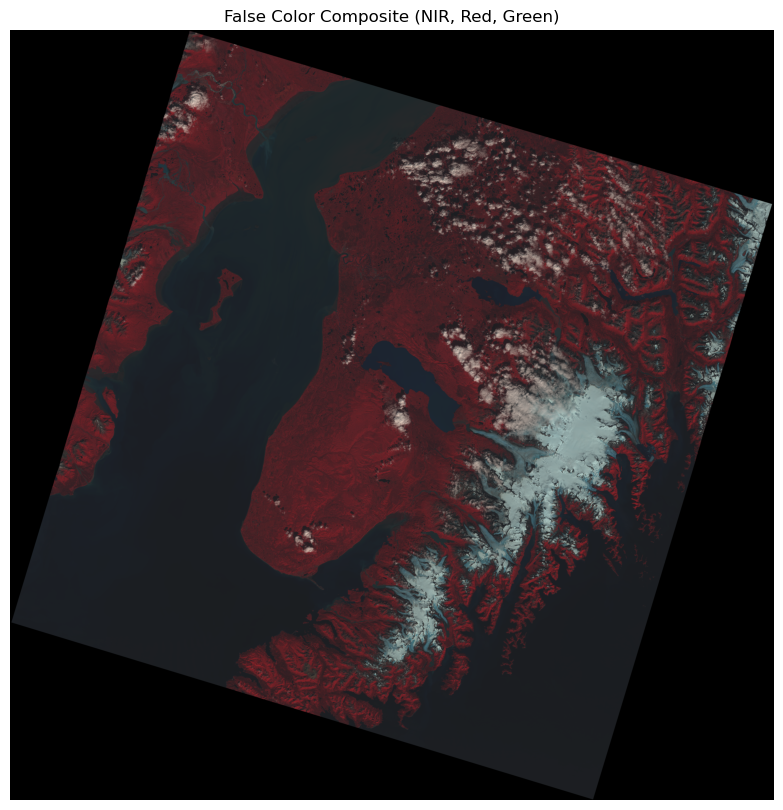

NameError: name 'profile' is not defined

In [33]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Paths to your TIFF files
band5_path = 'Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_B5.TIF'  # Near-Infrared
band4_path = 'Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_B4.TIF'  # Red
band3_path = 'Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_B3.TIF'  # Green

# Open the bands
with rasterio.open(band5_path) as band5:
    b5 = band5.read(1)

with rasterio.open(band4_path) as band4:
    b4 = band4.read(1)

with rasterio.open(band3_path) as band3:
    b3 = band3.read(1)

# Stack bands into a single 3D array (R, G, B)
false_color = np.dstack((b5, b4, b3))

# Optional: Stretch the values to [0, 1] for display
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

false_color_norm = normalize(false_color)

# Display the false color image
plt.figure(figsize=(10, 10))
plt.imshow(false_color_norm)
plt.title('False Color Composite (NIR, Red, Green)')
plt.axis('off')
plt.show()


# Save the new stacked image
output_path = 'Landsat8_Images/'

# Update profile for 3 bands
profile.update(
    count=3,  # 3 bands (R, G, B)
    dtype=rasterio.uint16  # Keep same dtype or adjust if needed
)

# Save
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(false_color)

print(f"False color image saved to: {output_path}")


In [35]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Paths to your TIFF files
band5_path = 'Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_B5.TIF'  # Near-Infrared
band4_path = 'Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_B4.TIF'  # Red
band3_path = 'Landsat8_Images/extracted/LC08_L1TP_069018_20230817_20230825_02_T1_B3.TIF'  # Green

# Open the bands
with rasterio.open(band5_path) as band5:
    b5 = band5.read(1)
    profile = band5.profile  # Save metadata to reuse later

with rasterio.open(band4_path) as band4:
    b4 = band4.read(1)

with rasterio.open(band3_path) as band3:
    b3 = band3.read(1)

# Stack bands into (bands, rows, columns)
false_color = np.stack((b5, b4, b3))

# Optional: Normalize if you want it prettier for visualization (not for saving raw data)
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Save the new stacked image
output_path = 'Landsat8_Images/false_color_compositeKm.tif'


# Update profile for 3 bands
profile.update(
    count=3,  # 3 bands (R, G, B)
    dtype=rasterio.uint16  # Keep same dtype or adjust if needed
)

# Save
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(false_color)

print(f"False color image saved to: {output_path}")


False color image saved to: Landsat8_Images/false_color_compositeKm.tif


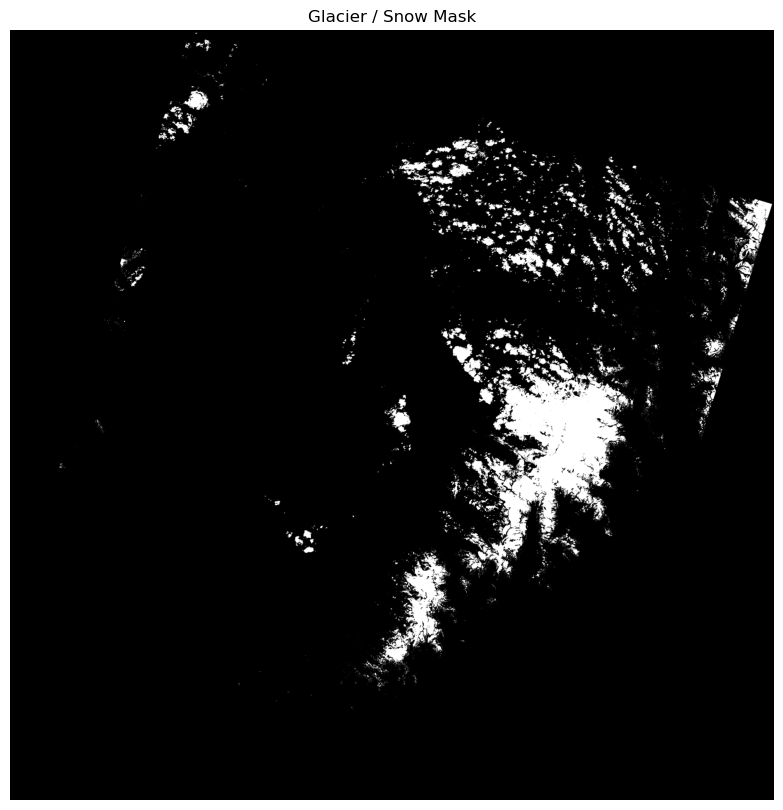

Glacier mask saved successfully!


In [37]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the TIFF
with rasterio.open('Landsat8_Images/false_color_compositeKm.tif') as src:
    img = src.read()  # Shape: (bands, height, width)
    profile = src.profile

# Normalize bands to 0-1
img = img.astype(np.float32)
img /= img.max()

# Let's say Band 1 (Red), Band 2 (Green), Band 3 (Blue)
# You can pick based on your composite setup!

red = img[0]
green = img[1]
blue = img[2]

# Define a basic glacier mask: high reflectance in visible bands
glacier_mask = (blue > 0.3) & (green > 0.3) & (red > 0.3)

# Visualize the classification
plt.figure(figsize=(10, 10))
plt.imshow(glacier_mask, cmap='gray')
plt.title('Glacier / Snow Mask')
plt.axis('off')
plt.show()

# Update profile for single band, uint8
profile.update(
    dtype=rasterio.uint8,
    count=1
)

with rasterio.open('Landsat8_Images/glacier_mask.tif', 'w', **profile) as dst:
    dst.write(glacier_mask.astype(rasterio.uint8), 1)

print("Glacier mask saved successfully!")


In [39]:
import rasterio

with rasterio.open('Landsat8_Images/glacier_mask.tif') as src:
    print(src.bounds)


BoundingBox(left=490785.0, bottom=6541485.0, right=731715.0, top=6784515.0)


In [99]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
import json

# Path to your input image
input_tif = 'Landsat8_Images/glacier_mask.tif'

# Define your crop area (xmin, ymin, xmax, ymax) - in the same CRS as the raster!
crop_bounds = (575000, 6700000 , 701000 , 6000000)  # 🔥 you set these numbers

# Open the image
with rasterio.open(input_tif) as src:
    # Create a shapely box (polygon) from bounds
    bbox = box(*crop_bounds)

    # Convert to GeoJSON-like dict
    geo = gpd.GeoSeries([bbox], crs=src.crs).to_json()
    shapes = [json.loads(geo)['features'][0]['geometry']]

    # Mask (crop) the image
    out_image, out_transform = mask(src, shapes, crop=True)
    
    # Update the metadata
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Path to save the cropped image
output_tif = 'Landsat8_Images/cropped_false_color.tif'

# Save the cropped image
with rasterio.open(output_tif, "w", **out_meta) as dest:
    dest.write(out_image)

print(f"✅ Cropped image saved to {output_tif}")
plt.show()

✅ Cropped image saved to Landsat8_Images/cropped_false_color.tif


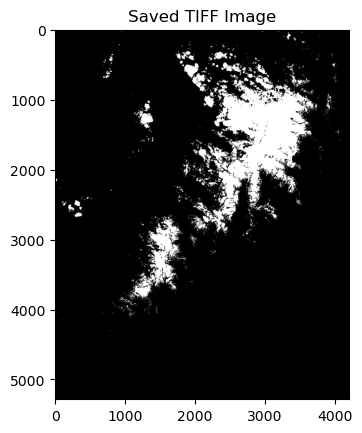

In [101]:
# Path to your saved TIFF file
tif_path = 'Landsat8_Images/cropped_false_color.tif'

# Open the TIFF file using rasterio
with rasterio.open(tif_path) as src:
    # Read the image data as a 2D numpy array (band 1)
    image_data = src.read(1)

    # Plot the image using matplotlib
    plt.imshow(image_data, cmap='gray')  # You can use other colormaps if needed
    plt.title("Saved TIFF Image")
    plt.show()

In [13]:
import tarfile

file_path = r"C:/Users/couse/OneDrive - Ulster University/Postgrad/PGCert Remote Sensing and GIS/EGM 722/EGM722_Project/Landsat8_Images/LC08_L1GT_072043_20170501_20201016_02_T2 (2).tar"
extract_path = r"C:/Users/couse/OneDrive - Ulster University/Postgrad/PGCert Remote Sensing and GIS/EGM 722/EGM722_Project/Landsat8_Images/extracted"

# Open as a tar file
with tarfile.open(file_path, "r") as tar:
    tar.extractall(path=extract_path)

print("Extraction complete!")


Extraction complete!


In [107]:
import rasterio
import numpy as np

# Open the glacier mask
with rasterio.open('Landsat8_Images/cropped_false_color.tif') as mask_src:
    glacier_mask = mask_src.read(1)  # Read first band
    transform = mask_src.transform
    pixel_size_x = transform[0]     # pixel width
    pixel_size_y = -transform[4]    # pixel height (negative, so make positive)

# Calculate area per pixel (in square meters)
area_per_pixel = pixel_size_x * pixel_size_y  # (e.g., 30m x 30m = 900 m² for Landsat)

# Count how many pixels are classified as glacier/snow
glacier_pixels = np.sum(glacier_mask == 1)

# Total area of glacier/snow
total_glacier_area_m2 = glacier_pixels * area_per_pixel
total_glacier_area_km2 = total_glacier_area_m2 / 1e6  # convert to square kilometers

print(f"Glacier / Snow Area: {total_glacier_area_km2:.2f} km²")


Glacier / Snow Area: 1952.93 km²


In [ ]:
help(api.download_request)

In [ ]:
help(api.payloads)